In [20]:
import os
import re
import sys
import cv2
import math
import time
import scipy
import argparse
import numpy as np
from joblib import Parallel, delayed
import util
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from config_reader import config_reader
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
torch.cuda.set_device(3)
torch.set_num_threads(torch.get_num_threads())

In [22]:
weight_name = './model/pose_model.pth'

blocks = {}

# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
           
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]
          
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
          
             
block0  = [{'conv1_1':[3,64,3,1,1]},{'conv1_2':[64,64,3,1,1]},{'pool1_stage1':[2,2,0]},{'conv2_1':[64,128,3,1,1]},{'conv2_2':[128,128,3,1,1]},{'pool2_stage1':[2,2,0]},{'conv3_1':[128,256,3,1,1]},{'conv3_2':[256,256,3,1,1]},{'conv3_3':[256,256,3,1,1]},{'conv3_4':[256,256,3,1,1]},{'pool3_stage1':[2,2,0]},{'conv4_1':[256,512,3,1,1]},{'conv4_2':[512,512,3,1,1]},{'conv4_3_CPM':[512,256,3,1,1]},{'conv4_4_CPM':[256,128,3,1,1]}]

blocks['block1_1']  = [{'conv5_1_CPM_L1':[128,128,3,1,1]},{'conv5_2_CPM_L1':[128,128,3,1,1]},{'conv5_3_CPM_L1':[128,128,3,1,1]},{'conv5_4_CPM_L1':[128,512,1,1,0]},{'conv5_5_CPM_L1':[512,38,1,1,0]}]

blocks['block1_2']  = [{'conv5_1_CPM_L2':[128,128,3,1,1]},{'conv5_2_CPM_L2':[128,128,3,1,1]},{'conv5_3_CPM_L2':[128,128,3,1,1]},{'conv5_4_CPM_L2':[128,512,1,1,0]},{'conv5_5_CPM_L2':[512,19,1,1,0]}]

for i in range(2,7):
    blocks['block%d_1'%i]  = [{'Mconv1_stage%d_L1'%i:[185,128,7,1,3]},{'Mconv2_stage%d_L1'%i:[128,128,7,1,3]},{'Mconv3_stage%d_L1'%i:[128,128,7,1,3]},{'Mconv4_stage%d_L1'%i:[128,128,7,1,3]},
{'Mconv5_stage%d_L1'%i:[128,128,7,1,3]},{'Mconv6_stage%d_L1'%i:[128,128,1,1,0]},{'Mconv7_stage%d_L1'%i:[128,38,1,1,0]}]
    blocks['block%d_2'%i]  = [{'Mconv1_stage%d_L2'%i:[185,128,7,1,3]},{'Mconv2_stage%d_L2'%i:[128,128,7,1,3]},{'Mconv3_stage%d_L2'%i:[128,128,7,1,3]},{'Mconv4_stage%d_L2'%i:[128,128,7,1,3]},
{'Mconv5_stage%d_L2'%i:[128,128,7,1,3]},{'Mconv6_stage%d_L2'%i:[128,128,1,1,0]},{'Mconv7_stage%d_L2'%i:[128,19,1,1,0]}]

In [28]:
def make_layers(cfg_dict):
    layers = []
    for i in range(len(cfg_dict)-1):
        one_ = cfg_dict[i]
        for k,v in one_.iteritems():      
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2] )]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride = v[3], padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]
    one_ = cfg_dict[-1].keys()
    k = one_[0]
    v = cfg_dict[-1][k]
    conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride = v[3], padding=v[4])
    layers += [conv2d]
    return nn.Sequential(*layers)

In [31]:
layers = []
for i in range(len(block0)):
    one_ = block0[i]
    for k,v in one_.iteritems():      
        if 'pool' in k:
            layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2] )]
        else:
            conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride = v[3], padding=v[4])
            layers += [conv2d, nn.ReLU(inplace=True)]  
       
models = {}           
models['block0'] = nn.Sequential(*layers)        

for k,v in blocks.iteritems():
    models[k] = make_layers(v)

In [34]:
layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 

In [32]:
class pose_model(nn.Module):
    def __init__(self,model_dict,transform_input=False):
        super(pose_model, self).__init__()
        self.model0   = model_dict['block0']
        self.model1_1 = model_dict['block1_1']        
        self.model2_1 = model_dict['block2_1']  
        self.model3_1 = model_dict['block3_1']  
        self.model4_1 = model_dict['block4_1']  
        self.model5_1 = model_dict['block5_1']  
        self.model6_1 = model_dict['block6_1']  
        
        self.model1_2 = model_dict['block1_2']        
        self.model2_2 = model_dict['block2_2']  
        self.model3_2 = model_dict['block3_2']  
        self.model4_2 = model_dict['block4_2']  
        self.model5_2 = model_dict['block5_2']  
        self.model6_2 = model_dict['block6_2']
        
    def forward(self, x):    
        out1 = self.model0(x)
        
        out1_1 = self.model1_1(out1)
        out1_2 = self.model1_2(out1)
        out2  = torch.cat([out1_1,out1_2,out1],1)
        
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)
        out3   = torch.cat([out2_1,out2_2,out1],1)
        
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)
        out4   = torch.cat([out3_1,out3_2,out1],1)

        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)
        out5   = torch.cat([out4_1,out4_2,out1],1)  
        
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)
        out6   = torch.cat([out5_1,out5_2,out1],1)         
              
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)
        
        return out6_1,out6_2        

In [41]:
model = pose_model(models)     
model.load_state_dict(torch.load(weight_name))
model.cuda()
model.float()
model.eval()

pose_model(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inp

In [42]:
param_, model_ = config_reader()

In [43]:
test_image = './sample_image/segm.png'

In [44]:
plt.imread(test_image).shape

(512, 512, 4)

In [45]:
%%time

oriImg = cv2.imread(test_image) # B,G,R order
# imageToTest = Variable(T.transpose(T.transpose(T.unsqueeze(torch.from_numpy(oriImg).float(),0),2,3),1,2),volatile=True).cuda()

with torch.no_grad():
    imageToTest = Variable(T.transpose(T.transpose(T.unsqueeze(torch.from_numpy(oriImg).float(),0),2,3),1,2)).cuda()


multiplier = [x * model_['boxsize'] / oriImg.shape[0] for x in param_['scale_search']]

heatmap_avg = torch.zeros((len(multiplier),19,oriImg.shape[0], oriImg.shape[1])).cuda()
paf_avg = torch.zeros((len(multiplier),38,oriImg.shape[0], oriImg.shape[1])).cuda()
#print heatmap_avg.size()


CPU times: user 937 ms, sys: 462 ms, total: 1.4 s
Wall time: 140 ms


In [46]:
%%time

for m in range(len(multiplier)):
    scale = multiplier[m]
    h = int(oriImg.shape[0]*scale)
    w = int(oriImg.shape[1]*scale)
    pad_h = 0 if (h%model_['stride']==0) else model_['stride'] - (h % model_['stride']) 
    pad_w = 0 if (w%model_['stride']==0) else model_['stride'] - (w % model_['stride'])
    new_h = h+pad_h
    new_w = w+pad_w

    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_['stride'], model_['padValue'])
    imageToTest_padded = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5
    
    feed = Variable(T.from_numpy(imageToTest_padded)).cuda()      
    output1,output2 = model(feed)
    print ('output1', output1.size())
    print ('output2', output2.size())
    heatmap = nn.UpsamplingBilinear2d((oriImg.shape[0], oriImg.shape[1])).cuda()(output2)
    
    paf = nn.UpsamplingBilinear2d((oriImg.shape[0], oriImg.shape[1])).cuda()(output1)       

    heatmap_avg[m] = heatmap[0].data
    paf_avg[m] = paf[0].data  


('output1', torch.Size([1, 38, 23, 23]))
('output2', torch.Size([1, 19, 23, 23]))
('output1', torch.Size([1, 38, 46, 46]))
('output2', torch.Size([1, 19, 46, 46]))
('output1', torch.Size([1, 38, 69, 69]))
('output2', torch.Size([1, 19, 69, 69]))


/home/e.zholkovskiy/anaconda3/envs/py27/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:221: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


('output1', torch.Size([1, 38, 92, 92]))
('output2', torch.Size([1, 19, 92, 92]))
CPU times: user 2.76 s, sys: 239 ms, total: 3 s
Wall time: 252 ms


In [47]:
multiplier

[0.359375, 0.71875, 1.078125, 1.4375]

In [22]:
%%time

heatmap_avg = T.transpose(T.transpose(T.squeeze(T.mean(heatmap_avg, 0)),0,1),1,2).cuda() 
paf_avg     = T.transpose(T.transpose(T.squeeze(T.mean(paf_avg, 0)),0,1),1,2).cuda() 
heatmap_avg=heatmap_avg.cpu().numpy()
paf_avg    = paf_avg.cpu().numpy()


CPU times: user 31.3 ms, sys: 42.2 ms, total: 73.5 ms
Wall time: 71.8 ms


In [ ]:
tic = time.time()

all_peaks = []
peak_counter = 0

#maps = 
for part in range(18):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param_['thre1']))
#    peaks_binary = T.eq(
#    peaks = zip(T.nonzero(peaks_binary)[0],T.nonzero(peaks_binary)[0])
    
    peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
    
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)
    
    
connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                vec = np.divide(vec, norm)
                
                startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > param_['thre2'])[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

canvas = cv2.imread(test_image) # B,G,R order
for i in range(18):
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

stickwidth = 4

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

#Parallel(n_jobs=1)(delayed(handle_one)(i) for i in range(18))

toc =time.time()
print ('time is %.5f'%(toc-tic)     )
cv2.imwrite('result.png',canvas)   

In [ ]:
alpha = (plt.imread(test_image)[:,:,3]*255).astype(np.uint8)

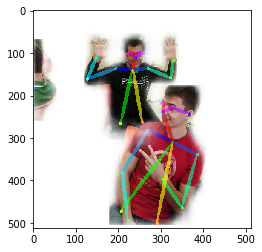

In [67]:
plt.imshow(np.stack([r,g,b,alpha], axis=2))

In [18]:
plt.figure(figsize=(7,7))
b,g,r = cv2.split(canvas)
canvas_rgb = cv2.merge((r,g,b,alpha))
plt.imshow(canvas_rgb)

NameError: name 'canvas' is not defined

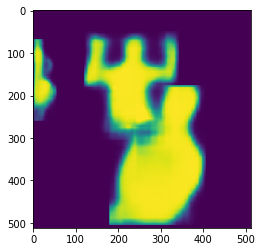

In [52]:
alpha.max()

255